# Programming exercise \#1 of ESS 412/512

We will do 3 exercises:
## 1. Travel-time curves in a 1D Earth model (chapter 4, question 8 of ITS). 10 points.
## 2. Global phase recognition in seismograms from teleseismimc earthquakes. 10 points.
## 3. Travel-time tomography in a 2D Earth (chapter 5, question2 of the 3rd edition of ITS). 10 points.

## 1. Travel-time in a 1D Earth


Write a computer program in this notebook to solve Chapter 4, Exercise 8: Calculate travel time curves for an oceanic crustal model using ray tracing. 

In this programming exercise, you will be expected to document your scripting and construct your code using best-practices for python programming. Some resources to get started in python are provided by the [Software Carpentry](!https://swcarpentry.github.io/python-novice-inflammation/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt


We will need the function ```layerxt``` that calculate ``dX`` and ``dT`` as a function of the ray parameter ``p``, layer thickness, and slowness at the top and bottom of a given layer with a constant velocity gradient.

In [2]:
# LAYERXT calculates dx and dt for a ray in a layer with a linear
#   velocity gradient.  This is a highly modified version of a
#   Fortran subroutine in Chris Chapman's WKBJ program.
#
# Inputs:   p     =  horizontal slowness
#           h     =  layer thickness
#           utop  =  slowness at top of layer
#           ubot  =  slowness at bottom of layer
# Returns:  dx    =  range offset
#           dt    =  travel time
#           irtr  =  return code
#                 = -1,  zero thickness layer
#                 =  0,  ray turned above layer
#                 =  1,  ray passed through layer
#                 =  2,  ray turned in layer, 1 leg counted in dx,dt
def layerxt(p, h, utop, ubot):
  # returns [dx, dt, irtr]
  
    if p >= utop:
        return [0.0, 0.0, 0]
    elif h==0:
        return [0.0, 0.0, -1]
    else:
        b = 1.0/(ubot*h) - 1.0/(utop*h)
    def eta(u): return np.sqrt(u**2 - p**2)
    def x(u): return eta(u)/(u*b*p)
    def t(u): return (np.log((u + eta(u))/p))/b
    if utop == ubot:
        return [h*p/eta(utop), h*utop**2/eta(utop), 1 ]
    elif p>=ubot:
        return [x(utop), t(utop), 2]
    else:
        return [x(utop) - x(ubot), t(utop) - t(ubot), 1]

Now we will tackle Exercise 8 from Chapter 4 in "Introduction to Seismology".

Consider MARMOD, a velocity-versus-depth model, which is typical of much of the oceanic crust (Table 1). Linear velocity gradients are assumed to exist at intermediate depths in the model; for example, the P velocity at 3.75 km is 6.9 km/s.Write a computer program to trace rays through this model and produce a P-wave T(X) curve, using 100 values of the ray parameter p equally spaced between 0.1236 and 0.2217 s/km.

Table 1. MARMOD, a generic marine seismic model

| Depth (km) | Vp (km/s) | Vs (km/s) | density (kg/dm^3) |
| ---------- | -------- | ---------| -------|
| 0.0 | 4.5 | 3.4 | 2.0|
| 1.5 | 6.8 | 3.75 | 2.8 |
| 6.0 | 7.0 | 3.85 | 2.9 |
| 10.0 | 8.1 | 4.7 | 3.1 |

Your program will involve an outer loop over ray parameter  $p$ and an inner loop over depth in the model.

For each ray, set ``x`` and ``t`` to zero and then, starting with the surface layer and proceeding downward, sum the
contributions, ``dx`` and ``dt``, from ```LAYERXT``` for each layer until the ray turns. This will give x and t for the ray from the surface to the turning point.

Multiply by two to obtain the total surface-to-surface values of $X(p)$ and $T(p)$. 

Now produce plots of: (a) $T(X)$ plotted with a reduction velocity of 8 km/s, (b) $X(p)$, and (c) $τ(p)$. On each plot, label the prograde and retrograde branches. Where might one anticipate that the largest amplitudes will occur?

### a) Define the depth and velocity model (2  points)

In [3]:
# solution
# Using the table from the book
depth = np.array([0, 1.5, 6, 6.5, 10])
alpha = np.array([4.5, 6.8, 7, 7, 8.1])
beta = np.array([2.4, 3.75, 3.85, 4.6, 4.7])
rho = np.array([2, 2.8, 2.9, 3.1, 3.1])

### b) Create the ray parameter vector with 100 values equally spaced between 0.1236 and 0.2217 s/km. (2 points)

In [4]:
# solution
p = np.linspace(0.1236, 0.2217, 100)

### c) Loop through ray parameters, calculate range offset and travel time. (4 points)

In [5]:
import pandas as pd

In [6]:
df = np.zeros([100,2])
for i in range(0,100,1):
    ray_parameter = p[i]
    dft = np.array([])
    for j in range(0,4,1):
        
        h = depth[j+1] - depth[j]
        utop = 1 / alpha[j]
        ubot = 1 / alpha[j+1]
        dx, dt, irtr = layerxt(ray_parameter, h, utop, ubot)
        dft = np.array([dx, dt])
        df[i] += 2* np.array([dx,dt])

### d) Plot the travel time T-X/8 and Tau curve as a function of distance (2 points)

(0.0, 100.0)

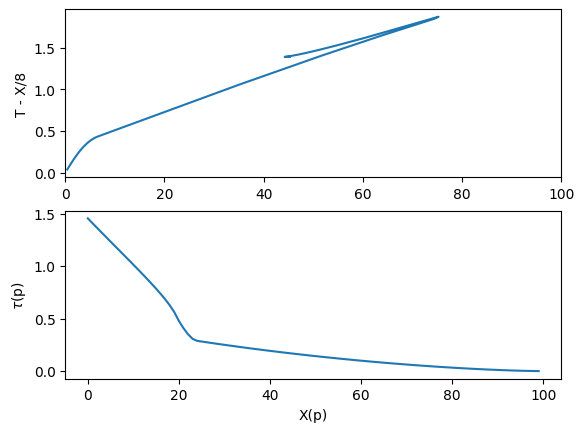

In [7]:
fig,ax=plt.subplots(2,1)

ax[0].plot(
    df[:,0], df[:,1] - df[:,0]/8
)
ax[0].set_ylabel('T - X/8')


ax[1].plot(
    df[:,1] - p*df[:,0]
)
ax[1].set_ylabel(r'$\tau$(p)')
ax[1].set_xlabel('X(p)')
ax[0].set_xlim(0,100)

## #2. Global Phase Recognition in teleseismic waveforms (10 points)

In this exercise, we will download the data from the recent M7.8 Earthquake in Turkey. The origin time of the earthquake was 2023-02-06 01:17:35 in UTC. The earthquake was a shallow crustal earthquakes at an approximate depth of 15 km.

We will look at the seisomgrams from a local station CI.HEC, specifically the HHZ channel.


Import modules

In [8]:
import obspy
from obspy.clients.fdsn import Client 

### 1. Collect earthquake metadata from IRIS

In [9]:
# get event info for the Turkey Earthquake 
client = Client("IRIS") # connect to IRIS earthquake service

# provide times t1 and t2 before and after earthquake 
t1 = obspy.UTCDateTime("2023-02-06") # for example 2000-01-01T00:00:00 for 1/1/2000
t2 = obspy.UTCDateTime("2023-02-09") #
cat = client.get_events(starttime=t1, endtime=t2, minmagnitude=7.6)
Mag = cat[0].magnitudes[0].mag
print("Magnitude of the earthquale:",Mag)
t0 = cat[0].origins[0].time
print("origin time of the earthquake:",t0)
lat0 = cat[0].origins[0].latitude
lon0 = cat[0].origins[0].longitude
depth0 = cat[0].origins[0].depth/1000 # convert to km
print("Hypocenter of the earthquake:",lat0,lon0,depth0)

Magnitude of the earthquale: 7.8
origin time of the earthquake: 2023-02-06T01:17:34.362000Z
Hypocenter of the earthquake: 37.2251 37.0209 10.0


### 2. Collect station metadata from IRIS 

In [10]:
st=client.get_stations(network="IU",station="DWPF",location="*",channel="BHZ",\
                       starttime=t0-1800,endtime=t0+86400,level="response")
#station information
slat=st[0][0].latitude
slon=st[0][0].longitude

### 3. Calculate the distance between source and receiver.

In [11]:
from obspy.geodetics.base import gps2dist_azimuth
from obspy.geodetics import locations2degrees
# find the great-arc distance, the azimmuth, and the backazimuth
dist,az,baz=gps2dist_azimuth(lat0,lon0,slat,slon)
print("great-arc distance in km",dist/1000.,"azimuth (deg)",az,"backazimuth (deg)",baz)
# find the angular distance between source and receiver
deg = locations2degrees(lat0,lon0,slat,slon)
print("angular distance (in deg)",deg)

great-arc distance in km 10343.73468037019 azimuth (deg) 309.12510462013506 backazimuth (deg) 44.480446325226296
angular distance (in deg) 92.84267952538302


### 4. Given a global Earth reference model (iasp91), predict the arrival time of global phases.

In [12]:
from obspy.taup import TauPyModel
model = TauPyModel(model="iasp91")
arrivals = model.get_travel_times(source_depth_in_km=depth0,
                                  distance_in_degree=deg)
print(arrivals)

35 arrivals
	P phase arrival at 792.809 seconds
	PcP phase arrival at 793.310 seconds
	pP phase arrival at 796.156 seconds
	sP phase arrival at 797.430 seconds
	PP phase arrival at 1014.851 seconds
	PKiKP phase arrival at 1080.512 seconds
	pPKiKP phase arrival at 1083.946 seconds
	sPKiKP phase arrival at 1085.201 seconds
	SKiKP phase arrival at 1295.159 seconds
	SKS phase arrival at 1426.298 seconds
	pSKS phase arrival at 1430.881 seconds
	sSKS phase arrival at 1432.165 seconds
	SKKS phase arrival at 1443.756 seconds
	S phase arrival at 1458.472 seconds
	ScS phase arrival at 1460.094 seconds
	pS phase arrival at 1462.873 seconds
	sS phase arrival at 1464.210 seconds
	SP phase arrival at 1530.530 seconds
	SP phase arrival at 1531.870 seconds
	SP phase arrival at 1531.873 seconds
	PS phase arrival at 1531.928 seconds
	PS phase arrival at 1533.282 seconds
	PS phase arrival at 1533.285 seconds
	PKIKKIKP phase arrival at 1820.496 seconds
	PKKP phase arrival at 1822.516 seconds
	SS phase arr

We can get the specific travel times, ray parameters, and incidence angles. The P wave is the first element of the array ``arrivals``, S wave seems to be the 14th element.

In [13]:
P=arrivals[0]
print("P wave ,",P.ray_param,P.time,P.incident_angle)
S=arrivals[13]
print("S wave ,",S.ray_param,S.time,S.incident_angle)

P wave , 263.6721074572062 792.8087823248172 13.888932548803195
S wave , 503.4738885052056 1458.4719811701636 15.398267220199802


### 5. Download seismic waveforms using the obspy function ``get_waveforms``, with the instrumental response, from IU.DWPF (a very good station in Florida) channel BHZ, location code ``00``. Download data from the origina time

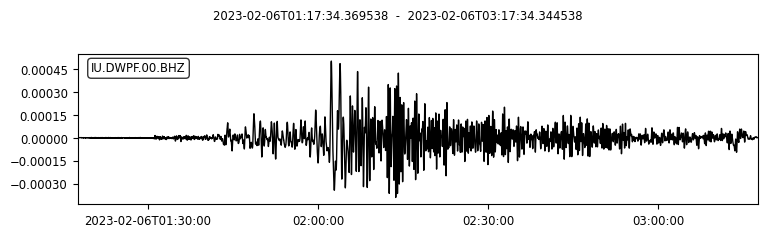

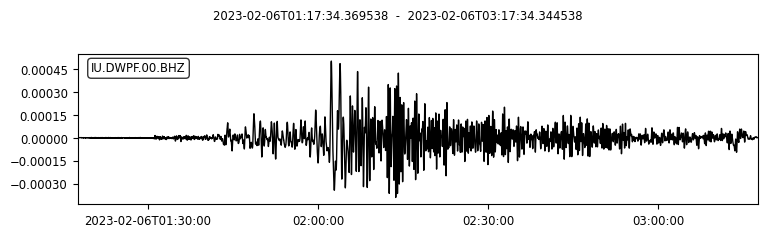

In [14]:
# download waveform
tr=client.get_waveforms(network="IU",station="DWPF",channel="BHZ",location="00",starttime=t0,endtime=t0+7200,attach_response=True);
tr.remove_response(output="DISP")
tr.plot() 


Wow the data is not super clear. That is actually quite typical to strike slip events. Clear phase are better found using thrust earthquakes. 

Let's look at a different earthquake and repeat the steps above.
We will focus on the M8.3 2013 Sea of Okhotsk earthquake. It occured on May 24, 2013 at 05:44:49 UTC. Based on above, download waveforms at the same station but for the other earthquake

### a) Collect metadata from IRIS about the earthquake (2 points)

In [15]:
#solution
client = Client("IRIS") # connect to IRIS earthquake service

# provide times t1 and t2 before and after earthquake 
t1 = obspy.UTCDateTime("2013-05-23") # for example 2000-01-01T00:00:00 for 1/1/2000
t2 = obspy.UTCDateTime("2013-05-25") #
cat = client.get_events(starttime=t1, endtime=t2, minmagnitude=8.2)
Mag = cat[0].magnitudes[0].mag
print("Magnitude of the earthquale:",Mag)
t0 = cat[0].origins[0].time
print("origin time of the earthquake:",t0)
lat0 = cat[0].origins[0].latitude
lon0 = cat[0].origins[0].longitude
depth0 = cat[0].origins[0].depth/1000 # convert to km
print("Hypocenter of the earthquake:",lat0,lon0,depth0)

Magnitude of the earthquale: 8.3
origin time of the earthquake: 2013-05-24T05:44:49.880000Z
Hypocenter of the earthquake: 54.815 153.3912 607.0


### b) Collect metadata from IRIS about the station (1 point)
We will use the same station IU.DWPF.00.BHZ.

In [16]:
# get station information
st=client.get_stations(network="IU",station="DWPF",location="*",channel="BHZ",\
                       starttime=t0-1800,endtime=t0+86400,level="response")
#station information
slat=st[0][0].latitude
slon=st[0][0].longitude

### c) Download seismic waveforms (1 point)

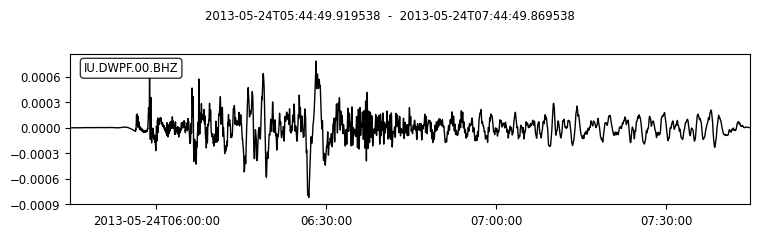

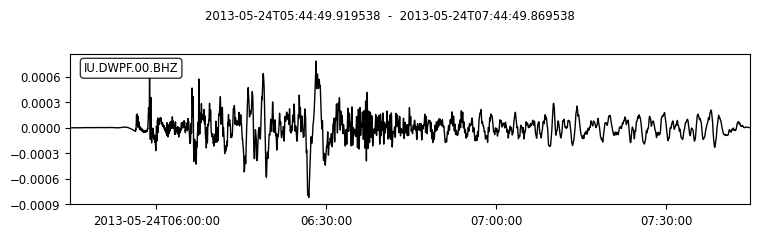

In [17]:
# download waveforms
tr=client.get_waveforms(network="IU",station="DWPF",channel="BHZ",location="00",starttime=t0,endtime=t0+7200,attach_response=True);
tr.remove_response(output="DISP")
tr.plot() 


### Measure travel time of P and S waves

Find the index and time at which the main global phases appear in the waveforms. 
Hints:

* The sampling rate of the data (found in ``tr[0].stats.sampling_rate``)
* Plot the waveforms using matplotlib. add grid and play with `xlim` to zoom in.

Write the solutions in the appropriate cell

In [18]:
period = 1/(tr[0].stats.sampling_rate)

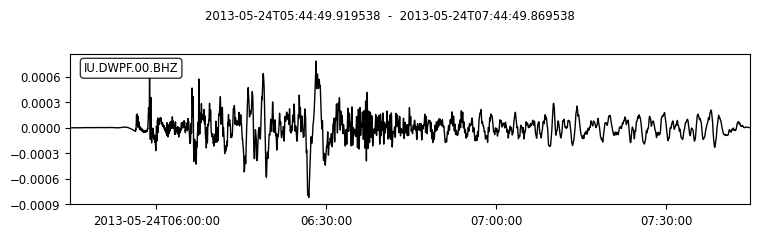

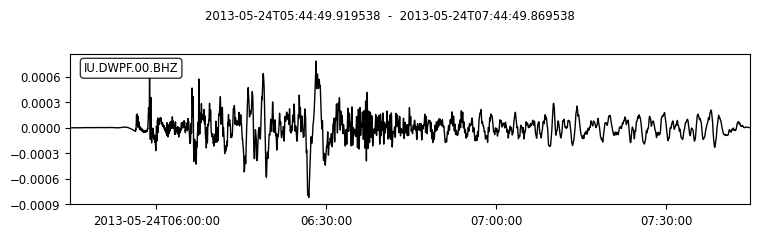

In [19]:
# download waveforms
tr=client.get_waveforms(network="IU",station="DWPF",channel="BHZ",location="00",starttime=t0,endtime=t0+7200,attach_response=True);
tr.remove_response(output="DISP")
tr.plot() 


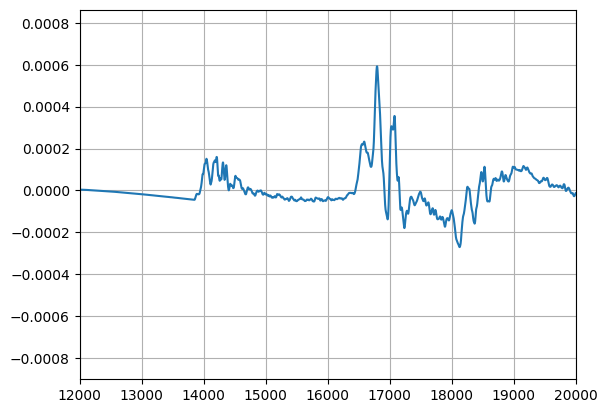

In [20]:
tr[0].data 

plt.plot(tr[0].data)
plt.xlim(12000,20000)
plt.grid()

In [21]:
period * 13800

690.0

## c) direct P wave (2 points)
Estimate the index and the time of arrival of the P wave from origin time.

In [22]:
# solution
iP = 13800 
tP = period * 13800


### d) direct S wave (2 points) 
Hint, this one is harder to find. You may guide yourself with plots of global phases that are annotated with seismic phase type (e.g., [IRIS resource](!https://ds.iris.edu/ds/products/globalstacks/)).

In [23]:
# solution
iS = 25550
tS = period * 25550


In [24]:
print(f'Direct P wave arrive: {tP} s, Direct S wave arrival: {tS} s')

Direct P wave arrive: 690.0 s, Direct S wave arrival: 1277.5 s


### e) Can you compare with the theoretical estimate. (2 points)
Use the TauP model from Obspy.

In [25]:
from obspy.geodetics.base import gps2dist_azimuth
from obspy.geodetics import locations2degrees
# find the great-arc distance, the azimmuth, and the backazimuth
dist,az,baz=gps2dist_azimuth(lat0,lon0,slat,slon)
print("great-arc distance in km",dist/1000.,"azimuth (deg)",az,"backazimuth (deg)",baz)
# find the angular distance between source and receiver
deg = locations2degrees(lat0,lon0,slat,slon)
print("angular distance (in deg)",deg)

great-arc distance in km 9438.40455431214 azimuth (deg) 46.32984346280102 backazimuth (deg) 331.7551002090156
angular distance (in deg) 84.70476397142163


In [26]:
from obspy.taup import TauPyModel
model = TauPyModel(model="iasp91")
arrivals = model.get_travel_times(source_depth_in_km=depth0,
                                  distance_in_degree=deg)
print(arrivals)

29 arrivals
	P phase arrival at 691.072 seconds
	PcP phase arrival at 693.044 seconds
	pP phase arrival at 819.927 seconds
	sP phase arrival at 881.175 seconds
	PP phase arrival at 898.373 seconds
	PKiKP phase arrival at 998.537 seconds
	pPKiKP phase arrival at 1138.821 seconds
	SKiKP phase arrival at 1155.697 seconds
	sPKiKP phase arrival at 1197.150 seconds
	SKS phase arrival at 1256.891 seconds
	SKKS phase arrival at 1265.081 seconds
	S phase arrival at 1269.311 seconds
	ScS phase arrival at 1276.008 seconds
	SP phase arrival at 1329.860 seconds
	pSKS phase arrival at 1439.528 seconds
	sS phase arrival at 1499.840 seconds
	sSKS phase arrival at 1503.444 seconds
	SS phase arrival at 1620.652 seconds
	PKIKKIKP phase arrival at 1765.990 seconds
	PKKP phase arrival at 1775.524 seconds
	SKIKKIKP phase arrival at 1923.085 seconds
	SKKP phase arrival at 1935.882 seconds
	PKIKKIKS phase arrival at 1981.414 seconds
	PKKS phase arrival at 1994.473 seconds
	SKIKKIKS phase arrival at 2138.320 s

In [27]:
# get travel time

## 3. 2D tomography model (10 points)

Consider a 2-D tomography. model consisting of a 20 by 20 grid of square cells, for a total of 400 model points, which are envenly sampled by 20 horizontal rays, 20 vertical rays, 39 diagonal rays at +45$^\circ$, and 39 diagonal rays at -45$^\circ$. The figure below shows details of the model and the ray numbering scheme. To a first-order approximation, the ray paths are assumed straight before the background velocity model is homogeneous and the 2-D velocity perturbtion are small. The cell sizes and seismic velocities are such that the travel times are 1 s across each cell, or $\sqrt{2}$ s diagonally. \
<img src="shearer_img.jpeg" alt="shearer" width="600"/>

<!-- ![Image](shearer_img.jpeg) -->



Given this configuration, we can write the travel-time perturbation inversion problem:

$ \mathbf{d} = \mathbf{G} \mathbf{m}$,

$\mathbf{d}$ is the travel-time data, a 1-D array, given by the rays defined in this problem.  $\mathbf{m}$ is the slowness perturbation model, it is a 1-D array that is reshaped  from the 2D grid.  $\mathbf{G}$ is the matrix that calculate the total ray path lengths specific for each ray given. 

### a) How many travel-time data points are there? (1 point)
Write N = integer.

In [28]:
# answer below
N = 118

### b) How many model parameters do we need to fit? (1 point)
write M = integer 

In [29]:
# answer below
M = 400

### c) Is the problem overdetermined or answer determined inverse problem? (1 point)
Type the answer in a lowercase string.

In [30]:
print('under-determined')

under-determined


#### d) Read the $\mathbf{G}$ matrix. (1 point)
Remember the in-class exercise. Start by writing the equations for each ray:

$d_i = \sum_k l_k m_k$, 

where $k$ is the index of the grid block that the ray travel through, and $l_k$ is the length of the ray within that block. $l_k$ is mostly $1$, sometimes $\sqrt{2}$.



* Upload the file called tomo_gmat.csv from Canvas. 





* Use ``pandas`` to read the CSV file. The file has 3 columns: 1 - indexes of the rows of G that have nonzero values, 2 - indexes of the columns of G that have non zeros values, 3 - the non zero values.

* Directly convert the pandas dataframe to a numpy array. examples are ``df.to_numpy()``.

* Declare G as a matrix filled with zeros and of dimensions NxM.


* Fill G of the rows and columns with non zero values.


read the dataframe and convert to numpa

Fill in the G matrix

In [31]:
df = pd.read_csv('tomo_gmat.csv')
g = df.to_numpy()
print(g.shape)
g

(1599, 3)


array([[  1.   ,   2.   ,   1.   ],
       [  1.   ,   3.   ,   1.   ],
       [  1.   ,   4.   ,   1.   ],
       ...,
       [117.   ,  19.   ,   1.414],
       [117.   ,  40.   ,   1.414],
       [118.   ,  20.   ,   1.414]])

In [32]:
print(g[i][1])

101.0


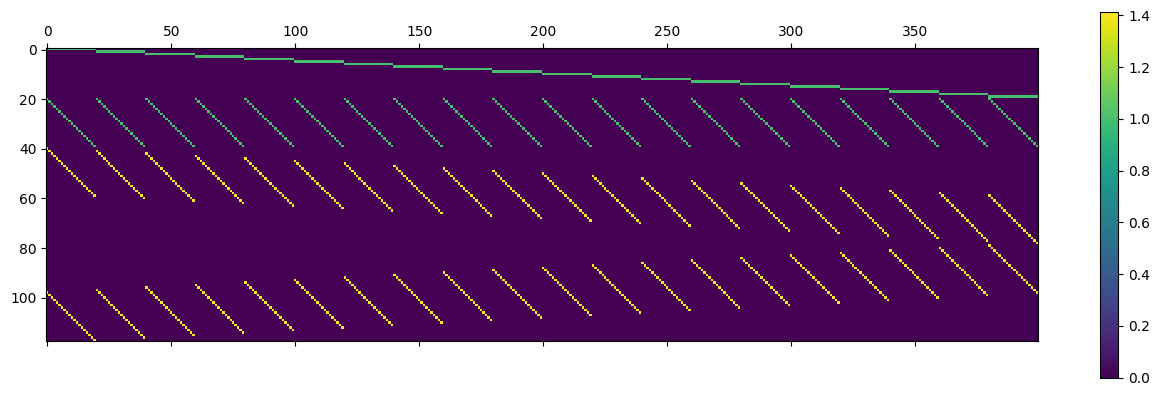

In [33]:
G = np.zeros((118,400))
# print(G)
for i in range(len(g)):
    G[int(g[i][0]-1)][int(g[i][1]-1)] = g[i][2]
    # break
plt.matshow(G)
plt.colorbar()

#### d - Bonus (+ 2 points)

Create the G matrix from scratch. Given each equation to express the residual travel time (i.e., giving each row of the G matrix), and the indexes of the grid block

In [34]:
#answer below

#### e) Impulse response test. (3 points)

The _true model_ on the left consists of a uniform slowness perturbation of –0.1 in the six cells defined by rows 14 to 16 and columns 12 to 13 in the grid, and 0.0 perturbations in all other cells. 

The _synthetic data_ is a set of travel time residuals.

The _recovered model_ is obtained by solving the inverse problem of $\mathbf{d} = \mathbf{G} \mathbf{m} $. Use the generalized inverse problem to solve. You can use ``np.linalg.lstsq`` to return the least-square solution (equivalent to the generalized inverse in class).


#### e.1 Write the vector for the true model (1 point) 
_hint_: you can initialize the matrix 20x20 with zeros. Then you can fill the elements with -0.1. Remember that python indexes from 0 to N-1, and that to fill a(12:13), you have to write a[11:13] to fill 2 elements. Use ``np.reshape`` to transform the 2D matrix to 1D array.

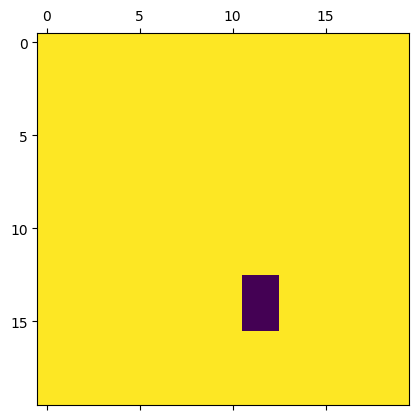

In [35]:
m = np.zeros((20,20))
m[13:16,11:13] = -0.1
m_reshaped = m.reshape(400,1)
plt.matshow(m)
# plt.colorbar()

#### e.2 Given G, calculate theoretical perturbation arrival time. (1 point)
_hint_: use the numpy function ``dot`` to apply a matrix to a vector.

In [36]:
# m = Gd
d = np.dot(G,m_reshaped)

#### e.3 Invert the synthetic data to recover the velocity model (2 points)

Use the generalized inverse or the least-square to recover the velocity model.

Use the matplotlib function ``plt.matshow()`` to plot the recovered model. 

/tmp/ipykernel_320435/1841634191.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m_inversion = np.linalg.lstsq(G,d)


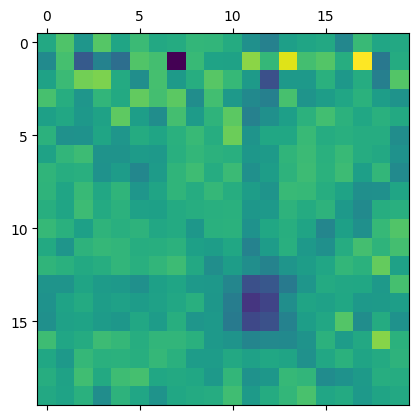

In [37]:
m_inversion = np.linalg.lstsq(G,d)
m_inversion = m_inversion[0].reshape(20,20)
plt.matshow(m_inversion)

In [38]:
# plot the matrix, 

### f) Checkerboard test (3 points)

Create a test model with alternating anomalies of in cell squares. Create synthetic data, invert them using damped least
squares, and plot the result.

We use the kronecker function ``kron`` in numpy to create a checkerboard model of a 20 x 20 grid.

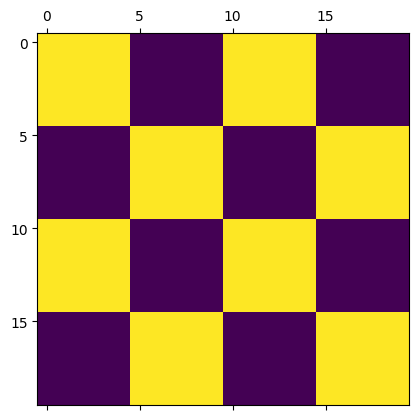

In [39]:
mm=np.kron([[1, 0] * 2, [0, 1] * 2] *2, np.ones((5, 5)))
plt.matshow(mm)

/tmp/ipykernel_320435/711503546.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  mm_inversion = np.linalg.lstsq(G,d)


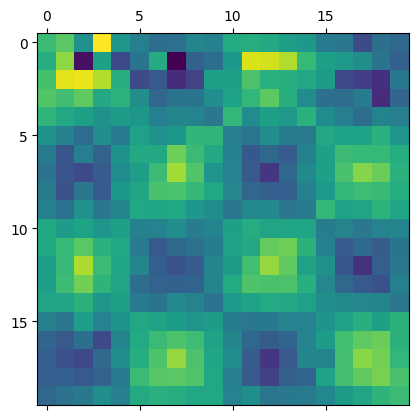

In [40]:
mm_reshape = mm.reshape(400,1)

d = np.dot(G,mm_reshape)

mm_inversion = np.linalg.lstsq(G,d)
mm_inversion = mm_inversion[0].reshape(20,20)
plt.matshow(mm_inversion)

reshape the array, calculate synthetics, and invert the model just as above. (3 points)

#### g) Best ray configurations (1 point)

By selecting a few rays or data points, you can gain some intuition for what the best ray configuration is.

/tmp/ipykernel_320435/348102164.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  HV_inverted = np.linalg.lstsq(GHV, d_HV)
/tmp/ipykernel_320435/348102164.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  D_inverted = np.linalg.lstsq(GD, d_D)


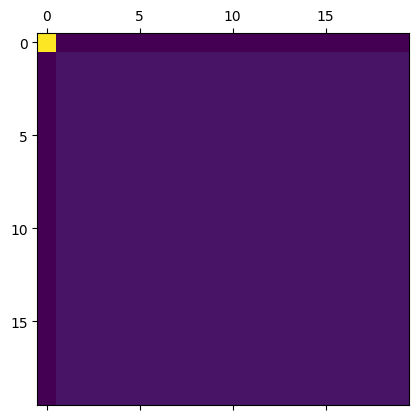

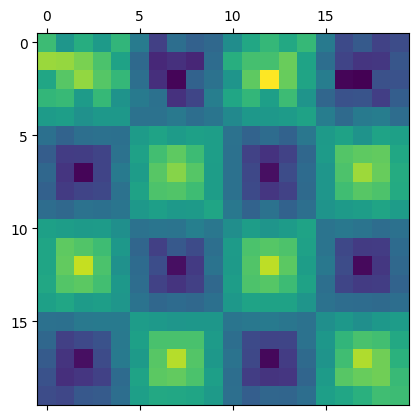

In [41]:
# below is a cell you can experiment to 1) create
GHV = G[0:40]
d_HV = np.dot(GHV, mm_reshape)
HV_inverted = np.linalg.lstsq(GHV, d_HV)
HV_inverted = HV_inverted[0].reshape(20,20)
plt.matshow(HV_inverted)

GD = G[40:118]
d_D = np.dot(GD, mm_reshape)
D_inverted = np.linalg.lstsq(GD, d_D)
D_inverted = D_inverted[0].reshape(20,20)
plt.matshow(D_inverted)

Below, answer the question: Is the best configuration a combination of horiztonal and vertical rays (answer: HV) or diagonal rays (answer D) ? 

In [42]:
# answer below either HV or D
print('D')

D
